In [1]:
import sys 
print(sys.version)

3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]


In [2]:
# python version 3.8.6rc1
import pandas as pd
import string
import util
import io
import os
from pprint import pprint
import spacy
import pickle
import re
import numpy as np

import warnings
warnings.filterwarnings(action='once')
#warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wei99\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wei99\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wei99\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\wei99\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Descriptive Analysis

In [3]:
# Count number of rows with each label without considering combination
comments = pd.read_csv("train.csv")
comments.iloc[:, 2:].sum(axis=0)

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

<AxesSubplot:title={'center':'Labels Frequency'}>

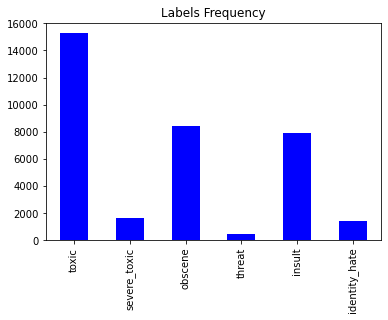

In [4]:
# Label Frequency
train_labels = comments[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
label_count = train_labels.sum()
label_count.plot(kind='bar', title='Labels Frequency', color='b')

In [5]:
# Count number of different combinations
comments[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].value_counts().reset_index(name='count')

,toxic,severe_toxic,obscene,threat,insult,identity_hate,count
0,0,0,0,0,0,0,143346
1,1,0,0,0,0,0,5666
2,1,0,1,0,1,0,3800
3,1,0,1,0,0,0,1758
4,1,0,0,0,1,0,1215
5,1,1,1,0,1,0,989
6,1,0,1,0,1,1,618
7,0,0,1,0,0,0,317
8,0,0,0,0,1,0,301
9,1,1,1,0,1,1,265


| Combination | Count |
| --- | --- |
| Toxic | 5666 |
| Toxic + Obscene + Insult | 3800 |
| Toxic + Obscene | 1758 |
| toxic + Insult | 1215 |
| Toxic + Severe Toxic + Obscene + Insult | 989 |
| Toxic + Obscene + Insult + Identity Hate | 618 |
| ... | ... |
| Obscene + Threat + Insult | 2 |
| Obscene + Threat | 2 |
| Toxic + Severe Toxic + Threat + Identity Hate | 1 |
| Toxic + Severe Toxic + Threat + Insult | 1 |


In [6]:
print(comments.iloc[:, 2:].sum(axis=0))
#(comments.iloc[:, 2:].sum())
# merging different kinds of harmful indicators
comments['harmful'] = comments.iloc[:, 2:].sum(axis=1)
#comments[comments['harmful']!=0] = 1
df = comments[['comment_text',"harmful"]]#.copy()
#selected.dtypes

df_harmful = df[df['harmful'] > 0] 
df_not_harmful = df[df['harmful'] == 0] 
df.head()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


,comment_text,harmful
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
print(df['harmful'].value_counts())

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: harmful, dtype: int64


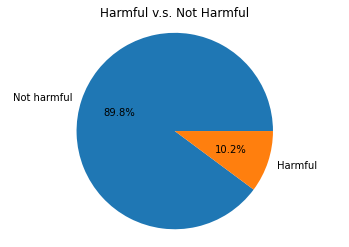

In [8]:
# pie chart for whole dataset
labels = ['Not harmful', 'Harmful']
sizes = [143346, 16225]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Harmful v.s. Not Harmful')


plt.show()

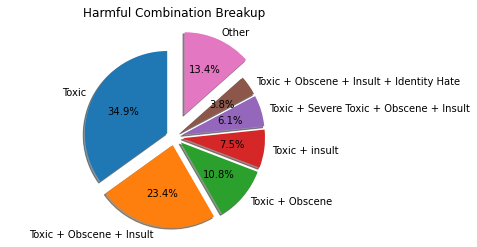

In [9]:
# pie chart Harmful Dataset
labels = ['Toxic', 'Toxic + Obscene + Insult', 'Toxic + Obscene', 'Toxic + insult', 'Toxic + Severe Toxic + Obscene + Insult', 'Toxic + Obscene + Insult + Identity Hate', 'Other']
sizes = [5666, 3800, 1758, 1215, 989, 618, 2179]

explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.3)

fig, ax = plt.subplots()
ax.pie(sizes,
       explode=explode,
       labels=labels,
       autopct='%1.1f%%',
       shadow=True,
       startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Harmful Combination Breakup')
plt.show()

# Data Cleaning

In [17]:
def prepossess(df):
    def remove_punctuation(text):
        #return str(text).translate(str.maketrans('', '', string.punctuation))
        text_nopunct = "".join([char if char not in string.punctuation else ' ' for char in str(text)])
        return text_nopunct

    def tokenize_text(text):
        tokens = nltk.word_tokenize(text) 
        tokens = [token.strip() for token in tokens]
        return tokens

    def remove_stopwords(tokens):
        stopword_list = nltk.corpus.stopwords.words('english')
        filtered_tokens = [token for token in tokens if token not in stopword_list]
        #filtered_text = ' '.join(filtered_tokens)    
        return filtered_tokens

    def expand_contractions(text, contraction_mapping):

        contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                          flags=re.IGNORECASE|re.DOTALL)
        def expand_match(contraction):
            match = contraction.group(0)
            first_char = match[0]
            expanded_contraction = contraction_mapping.get(match)\
                                    if contraction_mapping.get(match)\
                                    else contraction_mapping.get(match.lower())                       
            expanded_contraction = first_char+expanded_contraction[1:]
            return expanded_contraction

        expanded_text = contractions_pattern.sub(expand_match, text)
        expanded_text = re.sub("'", "", expanded_text)
        return expanded_text
    
    def remove_digit(text):
        text_nodigit = re.sub(r'\w*\d\w*', '',text).strip()
        return text_nodigit

    def stemming(tokenized_text):
        ps = nltk.PorterStemmer()
        stemmed = [ps.stem(word) for word in tokenized_text]
        return stemmed

    def lemmatize(tokenized_text):
        wn = nltk.WordNetLemmatizer()
        lemmatized = [wn.lemmatize(word) for word in tokenized_text]
        return lemmatized
    
    
    df["expand_contractions"] = df["comment_text"].apply(lambda x: expand_contractions(x.lower(), util.contraction_mapping))
    df["remove_punctuation"] = df["expand_contractions"].apply(lambda x: remove_punctuation(x))
    df["remove_digit"] = df["remove_punctuation"].apply(lambda x: remove_digit(x))
    df["tokenized"] = df["remove_digit"].apply(lambda x: tokenize_text(x))
    df['remove_stopwords'] =  df["tokenized"].apply(lambda x: remove_stopwords(x))
    df['stemmed'] =  df["remove_stopwords"].apply(lambda x: stemming(x))
    df['lemmatized'] =  df["stemmed"].apply(lambda x: lemmatize(x))
    return df

In [18]:
df_process = prepossess(df_harmful)
df_process.head()

C:\Users\wei99\AppData\Local\Temp\ipykernel_3676\2017534863.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["expand_contractions"] = df["comment_text"].apply(lambda x: expand_contractions(x.lower(), util.contraction_mapping))


,comment_text,harmful,expand_contractions,remove_punctuation,remove_digit,tokenized,remove_stopwords,stemmed,lemmatized,unchange_SR_Stemming,unchange_Stemming_Lemma
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,4,cocksucker before you piss around on my work,cocksucker before you piss around on my work,cocksucker before you piss around on my work,"[cocksucker, before, you, piss, around, on, my...","[cocksucker, piss, around, work]","[cocksuck, piss, around, work]","[cocksuck, piss, around, work]","[work, around, piss]","[cocksuck, work, around, piss]"
12,Hey... what is it..\n@ | talk .\nWhat is it......,1,hey... what is it..\n@ | talk .\nwhat is it......,hey what is it \n talk \nwhat is it ...,hey what is it \n talk \nwhat is it ...,"[hey, what, is, it, talk, what, is, it, an, ex...","[hey, talk, exclusive, group, wp, talibans, go...","[hey, talk, exclus, group, wp, taliban, good, ...","[hey, talk, exclus, group, wp, taliban, good, ...","[one, gang, sityush, ask, social, talk, non, b...","[destruct, question, talk, exclus, destroy, ga..."
16,"Bye! \n\nDon't look, come or think of comming ...",1,"bye! \n\ndo not look, come or think of comming...",bye \n\ndo not look come or think of comming...,bye \n\ndo not look come or think of comming...,"[bye, do, not, look, come, or, think, of, comm...","[bye, look, come, think, comming, back, tosser]","[bye, look, come, think, com, back, tosser]","[bye, look, come, think, com, back, tosser]","[tosser, think, come, look, back, bye]","[tosser, think, come, com, look, back, bye]"
42,You are gay or antisemmitian? \n\nArchangel WH...,4,you are gay or antisemmitian? \n\narchangel wh...,you are gay or antisemmitian \n\narchangel wh...,you are gay or antisemmitian \n\narchangel wh...,"[you, are, gay, or, antisemmitian, archangel, ...","[gay, antisemmitian, archangel, white, tiger, ...","[gay, antisemmitian, archangel, white, tiger, ...","[gay, antisemmitian, archangel, white, tiger, ...","[make, talk, pentagram, first, uh, head, would...","[make, talk, pentagram, slay, first, uh, head,..."
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",3,"fuck your filthy mother in the ass, dry!",fuck your filthy mother in the ass dry,fuck your filthy mother in the ass dry,"[fuck, your, filthy, mother, in, the, ass, dry]","[fuck, filthy, mother, ass, dry]","[fuck, filthi, mother, ass, dri]","[fuck, filthi, mother, as, dri]","[fuck, mother, ass]","[fuck, mother, filthi, dri]"


## Percentage of Changing After Each Step

### From Tokenization to Stopwords Removal

In [19]:
# From Tokenization to Stopwords Removal
tokenization = df_process['tokenized'].values.tolist()
count = 0
for words in tokenization:
    count += len(words)
count_srRemoval = 0
stopwords_removal = df_process['remove_stopwords']
for words in stopwords_removal:
    count_srRemoval += len(words)
total_stopwords_removed = count - count_srRemoval
percentage_change_after_sr = total_stopwords_removed / count
print('Total stopwords removed', total_stopwords_removed)
print('Percentage of Change After Stopwords Removal', percentage_change_after_sr)

Total stopwords removed 409092
Percentage of Change After Stopwords Removal 0.468809411667635


### From Stopwords Removal to Stemming

In [20]:
# From Stopwords Removal to Stemming
df_process['unchange_SR_Stemming'] = [list(set(a).intersection(set(b))) 
                      for a, b in zip(df_process.remove_stopwords, df_process.stemmed)]

SR = df_process['remove_stopwords'].values.tolist()
count_SR = 0
for words in SR:
    count_SR += len(words)

unchange_SR_Stemming = df_process['unchange_SR_Stemming'].values.tolist()
count_unchange_SR_Stemming = 0
for words in unchange_SR_Stemming:
    count_unchange_SR_Stemming += len(words)

count_change_SR_Stemming = count_SR-count_unchange_SR_Stemming
print('Total words after removing stopwords:', count_SR)
print('Total words that are NOT changed during stemming process:', count_unchange_SR_Stemming)
print('Total words that are changed after stemming process:', count_change_SR_Stemming)
print('Percentage of words that are not changed during stemming process',count_unchange_SR_Stemming/count_SR)
print('Percentage of words that are changed during stemming process', count_change_SR_Stemming/count_SR)

Total words after removing stopwords: 463527
Total words that are NOT changed during stemming process: 177070
Total words that are changed after stemming process: 286457
Percentage of words that are not changed during stemming process 0.38200579470020085
Percentage of words that are changed during stemming process 0.6179942052997992


C:\Users\wei99\AppData\Local\Temp\ipykernel_3676\98033826.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_process['unchange_SR_Stemming'] = [list(set(a).intersection(set(b)))


### From Stemming to Lemmatization

In [21]:
# From Stemming to Lemmatization
df_process['unchange_Stemming_Lemma'] = [list(set(a).intersection(set(b))) 
                      for a, b in zip(df_process.stemmed, df_process.lemmatized)]

SL = df_process['stemmed'].values.tolist()
count_SL = 0
for words in SL:
    count_SL += len(words)

unchange_Stemming_Lemma = df_process['unchange_Stemming_Lemma'].values.tolist()
count_unchange_Stemming_Lemma = 0
for words in unchange_Stemming_Lemma:
    count_unchange_Stemming_Lemma += len(words)

count_change_Stemming_Lemma = count_SL-count_unchange_Stemming_Lemma
print('Total words after stemming:', count_SL)
print('Total words that are NOT changed during lemmatization process:', count_unchange_Stemming_Lemma)
print('Total words that are changed after lemmatization process:', count_change_Stemming_Lemma)
print('Percentage of words that are not changed during lemmatization process',count_unchange_Stemming_Lemma/count_SL)
print('Percentage of words that are changed during lemmatization process', count_change_Stemming_Lemma/count_SL)

Total words after stemming: 463527
Total words that are NOT changed during lemmatization process: 289636
Total words that are changed after lemmatization process: 173891
Percentage of words that are not changed during lemmatization process 0.6248524897147307
Percentage of words that are changed during lemmatization process 0.37514751028526927


C:\Users\wei99\AppData\Local\Temp\ipykernel_3676\1903514544.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_process['unchange_Stemming_Lemma'] = [list(set(a).intersection(set(b)))


# LDA

In [ ]:
def token_to_corpus(token):
    data_words = token.values.tolist()
    #print(data_words[:1][0][:30])
    id2word = corpora.Dictionary(data_words)
    # Create Corpus
    texts = data_words
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]  
    return corpus, id2word

def generate_pyLDAvis(corpus, id2word,num_topics = 10, save = False):
    lda_model = LdaModel(corpus = corpus,
                     id2word = id2word,
                     num_topics = num_topics,
                     random_state = 0,
                     chunksize = 100,
                     alpha = "auto",
                     per_word_topics = True,
    )
    LDA_vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    if(save):
        pyLDAvis.save_html(LDA_vis, "./results/pyLDAvis.html")
    pprint(lda_model.print_topics())
    return LDA_vis




In [ ]:
simple_corpus, simple_id2word = token_to_corpus(df['lemmatized'][:100])
simple_LDA_vis = generate_pyLDAvis(simple_corpus, simple_id2word)
pyLDAvis.enable_notebook()
simple_LDA_vis